In [1]:
import SimpleITK as sitk
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact
from ipywidgets.widgets import IntSlider
import cv2
import ants as ants
import matplotlib.pyplot as plt
import pydicom
from matplotlib.colors import ListedColormap
import os
import PerfusionImaging.tool as perfusion
from scipy import ndimage
import ImageTool.tool as tool
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd
import scipy.io


2025-03-14 15:20:39.528309: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 15:20:39.535791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 15:20:39.545923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 15:20:39.545967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 15:20:39.554432: I tensorflow/core/platform/cpu_feature_gua

# include the path to the file. 

In [6]:
root = "/home/molloi-lab-linux2/smb_mount/Qiyu Zhang"
target = "MMD_patient6"
rest_sample = "."
save_path = os.path.join(root, target)
path_rest = os.path.join(save_path, rest_sample, "iodine_matrix_concentration.nii")
lmmask_path_rest = os.path.join(save_path, rest_sample, "Segmentation_2-Segment_1-label.nii")
bolus_rest = os.path.join(save_path, rest_sample, "mean_values.mat")
bolus_time = os.path.join(save_path, rest_sample, "relative_scan_times.mat")

# Read the mask file (left myocardial, right myocarial, full mask, aorta)

In [37]:
full_rest_mask = np.transpose(ants.image_read(lmmask_path_rest)[:, :, :-1], (1, 0, 2))
full_rest_mask = full_rest_mask[:, :, ::-1]


# Read the dcm and surestart

In [ ]:
dcm_rest = ants.image_read(path_rest)
ss_rest_value = scipy.io.loadmat(bolus_rest)['mean_values']
time_vec_gamma_rest = scipy.io.loadmat(bolus_time)["relative_scan_times"]

In [38]:
def plot_slice1(slice_index):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    current_slice_index = slice_index  # Update the global variable

    ax1.imshow(dcm_rest[:, :, slice_index], cmap='gray', vmin=0, vmax=1)
    ax1.imshow(full_rest_mask[:, :, slice_index], cmap='jet', vmin=0, vmax=1, alpha= 0.5)
    # ax1.imshow(dcm_rest_aorta[:, :, slice_index], cmap=ListedColormap(['black', 'green']),  vmin=0, vmax=1, alpha = 0.7)

    plt.show()

# Creating an interactive slider
interact(plot_slice1, slice_index=IntSlider(min=0, max=full_rest_mask.shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=785), Output()), _dom_classes=('widge…

<function __main__.plot_slice1(slice_index)>

# Find the aera under the curve as input_conc

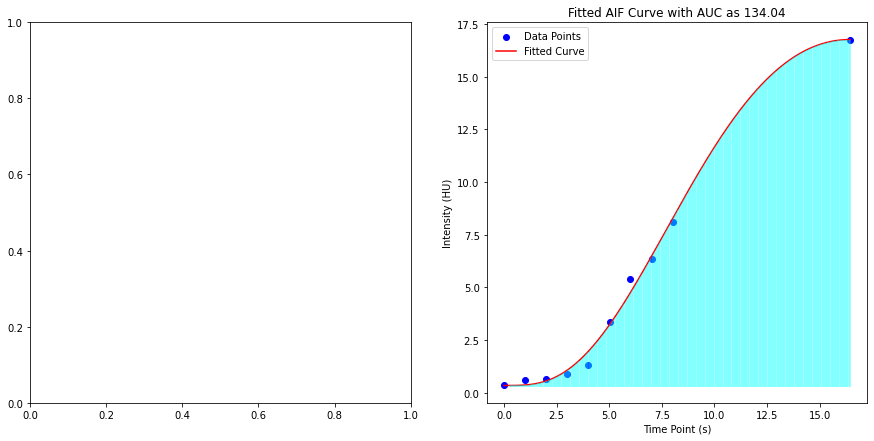

In [39]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))
input_conc, _ = perfusion.gamma_plot(ax1, time_vec_gamma_rest[:, 0], ss_rest_value[:, 0])
  

# Choose full/left/right myocardial to calculate

In [40]:
result = perfusion.compute_organ_metrics(dcm_rest, full_rest_mask, 0, input_conc, tissue_rho=0.24)


In [ ]:
%matplotlib inline
def plot_slice6(slice_index):
    plt.figure(figsize=(20, 12))

    plt.imshow(result["perf_map"][:, :, slice_index], cmap='jet', vmin=0, vmax=3)
    plt.show()

# Creating an interactive slider
interact(plot_slice6, slice_index=IntSlider(min=0, max=result["perf_map"].shape[2] - 1, step=1, value=50))

interactive(children=(IntSlider(value=50, description='slice_index', max=785), Output()), _dom_classes=('widge…

<function __main__.plot_slice6(slice_index)>

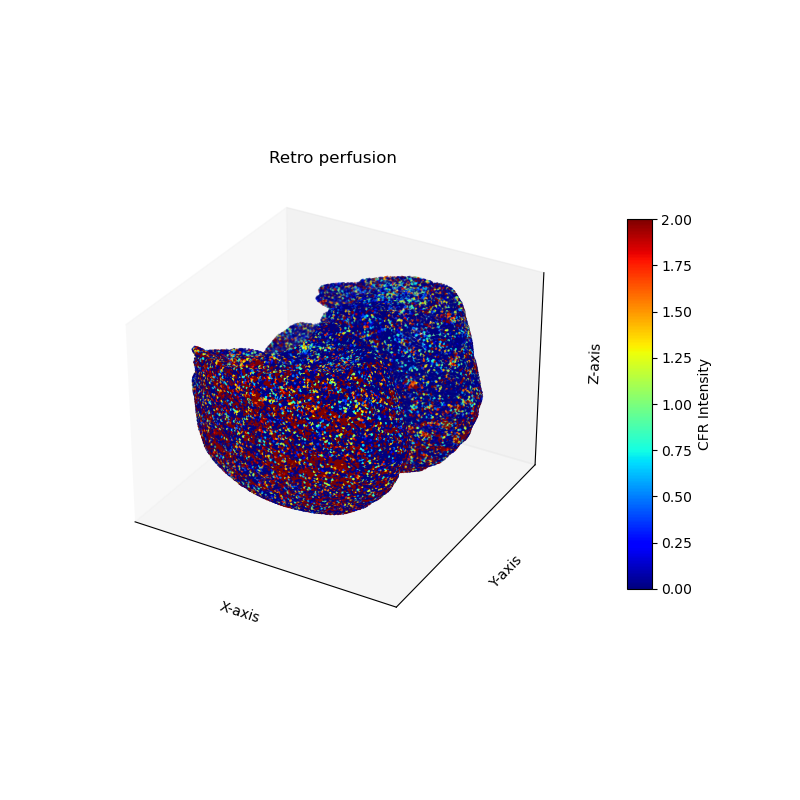

In [56]:
%matplotlib notebook
tool.plot3d(result["perf_map"][:], mask = full_rest_mask, sample_rate = 10, vmax=2, title="Retro perfusion")

In [44]:
col_vals = [result["perf"], result["perf_std"], result["flow"], result["flow_std"], result["organ_mass"], target]
col_names = ["perfusion", "perfusion_std", "flow", "flow_std", "mass", "date"]
df = pd.DataFrame({"parameters": col_names, "values": col_vals})
df.to_csv("/home/molloi-lab-linux2/Desktop/ZQY" + '/result.csv', index=False)
df

,parameters,values
0,perfusion,1.594471
1,perfusion_std,2.813566
2,flow,5783.176519
3,flow_std,10204.857422
4,mass,3627.01872
5,date,MMD_patient6
